#### bclc

# Churn Prediction Model

In [1]:
#Base
import numpy as np
import pandas as pd
from datetime import datetime

#Visualization
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

#Data Optimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import timeit

#Analysis
import math
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error

# 1. Eploratory Data Analysis

In [2]:
df=pd.read_csv('Churn label and features - 202301 to 202312 - 91.csv')

In [3]:
df.head(3)

elg_customer_bus_key  start_date EVER_BEEN_VSE previous_91_start_date  \
0                     4    20041008             Y             2023-07-04   
1                    11    20041009           NaN             2023-07-03   
2                    17    20041008           NaN             2023-07-04   

  previous_91_end_date subsequent_91_start_date subsequent_91_end_date  \
0           2023-09-29               2023-10-06             2023-10-30   
1           2023-10-01               2023-10-02             2023-12-31   
2           2023-09-25               2023-11-06             2023-12-13   

   previous_91_theo_net_win  subsequent_91_theo_net_win  \
0                   1254.78                     1960.94   
1                   2473.37                      891.08   
2                    888.47                      705.72   

   theo_net_win_retention  ...  features_91_s_theo_net_win  \
0                1.562784  ...                     1254.45   
1                0.360271  ...                      158.06   
2                0.794310  ...                      874.89   

  features_91_p_theo_net_win  features_91_l_theo_net_win  \
0                       0.32                         NaN   
1                        NaN                     2315.31   
2                      13.58                         NaN   

   features_91_t_theo_net_win  features_91_frequency  \
0                         NaN                     26   
1                         NaN                     86   
2                         NaN                     22   

   features_91_product_day_count  features_91_average_theo_net_win  \
0                             75                             13.79   
1                            225                             27.18   
2                             85                              9.76   

   delta_features_91_theo_net_win ACCOUNT_BALANCE_AMT  \
0                            7.26                0.19   
1                            2.49              504.00   
2                            5.21                0.43   

  SELF_EXCLUSION_DAYS_REMAINING  
0                         183.0  
1                          -1.0  
2                          -1.0  

[3 rows x 41 columns]

In [4]:
df = df[~df['EVER_BEEN_VSE'].str.contains('Y', na=False)]

In [5]:
df.head(3)

elg_customer_bus_key  start_date EVER_BEEN_VSE previous_91_start_date  \
1                    11    20041009           NaN             2023-07-03   
2                    17    20041008           NaN             2023-07-04   
3                    23    20041008           NaN             2023-09-02   

  previous_91_end_date subsequent_91_start_date subsequent_91_end_date  \
1           2023-10-01               2023-10-02             2023-12-31   
2           2023-09-25               2023-11-06             2023-12-13   
3           2023-09-27               2023-10-09             2023-12-30   

   previous_91_theo_net_win  subsequent_91_theo_net_win  \
1                   2473.37                      891.08   
2                    888.47                      705.72   
3                    105.50                     1424.06   

   theo_net_win_retention  ...  features_91_s_theo_net_win  \
1                0.360271  ...                      158.06   
2                0.794310  ...                      874.89   
3               13.498166  ...                       76.52   

  features_91_p_theo_net_win  features_91_l_theo_net_win  \
1                        NaN                     2315.31   
2                      13.58                         NaN   
3                      28.98                         NaN   

   features_91_t_theo_net_win  features_91_frequency  \
1                         NaN                     86   
2                         NaN                     22   
3                         NaN                     10   

   features_91_product_day_count  features_91_average_theo_net_win  \
1                            225                             27.18   
2                             85                              9.76   
3                             15                              1.16   

   delta_features_91_theo_net_win ACCOUNT_BALANCE_AMT  \
1                            2.49              504.00   
2                            5.21                0.43   
3                            0.60               22.18   

  SELF_EXCLUSION_DAYS_REMAINING  
1                          -1.0  
2                          -1.0  
3                          -1.0  

[3 rows x 41 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65635 entries, 1 to 73823
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   elg_customer_bus_key              65635 non-null  int64  
 1   start_date                        65635 non-null  int64  
 2   EVER_BEEN_VSE                     0 non-null      object 
 3   previous_91_start_date            56184 non-null  object 
 4   previous_91_end_date              56184 non-null  object 
 5   subsequent_91_start_date          56992 non-null  object 
 6   subsequent_91_end_date            56992 non-null  object 
 7   previous_91_theo_net_win          56184 non-null  float64
 8   subsequent_91_theo_net_win        56992 non-null  float64
 9   theo_net_win_retention            47220 non-null  float64
 10  churn_label                       65635 non-null  int64  
 11  latest_activity_date              65635 non-null  object 
 12  rece

In [7]:
date_format='%Y%m%d'
df['start_date'] = pd.to_datetime(df['start_date'],format=date_format)
date_format2='%Y-%m-%d'
df['features_91_end_date'] = pd.to_datetime(df['features_91_end_date'],format=date_format2)
df['player_life'] = (df['features_91_end_date'] - df['start_date']).dt.days

In [8]:
df['features_91_withdrawal_amount']=df['features_91_withdrawal_amount']*-1

In [9]:
df['delta_features_91_theo_net_win']=df['delta_features_91_theo_net_win']+abs(df['delta_features_91_theo_net_win'].min())

In [10]:
columns_to_drop = ['start_date','EVER_BEEN_VSE','previous_91_start_date','previous_91_end_date','subsequent_91_start_date','subsequent_91_end_date','latest_activity_date','SELF_EXCLUSION_DAYS_REMAINING','previous_91_theo_net_win','subsequent_91_theo_net_win','theo_net_win_retention','previous_91_frequency','subsequent_91_frequency','features_91_start_date','features_91_end_date','overall_days','features_91_average_theo_net_win','features_91_theo_net_win','features_91_s_theo_net_win','features_91_p_theo_net_win','features_91_l_theo_net_win','features_91_t_theo_net_win']  
df = df.drop(columns=columns_to_drop)

In [11]:
df['features_91_product_day_count'] = pd.to_numeric(df['features_91_product_day_count'], errors='coerce')
df['features_91_session_time_hours'] = pd.to_numeric(df['features_91_session_time_hours'], errors='coerce')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65635 entries, 1 to 73823
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   elg_customer_bus_key            65635 non-null  int64  
 1   churn_label                     65635 non-null  int64  
 2   recency                         65635 non-null  int64  
 3   overall_frequency               65635 non-null  int64  
 4   overall_average_theo_net_win    65635 non-null  float64
 5   features_91_deposit_amount      56136 non-null  float64
 6   features_91_withdrawal_amount   25235 non-null  float64
 7   features_91_session_time_hours  55824 non-null  float64
 8   features_91_encore_redemption   20923 non-null  float64
 9   features_91_crm_redemption      15779 non-null  float64
 10  features_91_paid_amount         56184 non-null  float64
 11  features_91_s_paid_amount       46953 non-null  float64
 12  features_91_p_paid_amount       

In [13]:
df.set_index('elg_customer_bus_key', inplace=True)

In [14]:
df.head(3)

churn_label  recency  overall_frequency  \
elg_customer_bus_key                                            
11                              1        0                243   
17                              0       18                 46   
23                              0        1                 15   

                      overall_average_theo_net_win  \
elg_customer_bus_key                                 
11                                           24.69   
17                                            4.55   
23                                            0.56   

                      features_91_deposit_amount  \
elg_customer_bus_key                               
11                                       18635.0   
17                                         925.0   
23                                         900.0   

                      features_91_withdrawal_amount  \
elg_customer_bus_key                                  
11                                           3725.0   
17                                              NaN   
23                                              NaN   

                      features_91_session_time_hours  \
elg_customer_bus_key                                   
11                                            678.41   
17                                             52.71   
23                                            134.17   

                      features_91_encore_redemption  \
elg_customer_bus_key                                  
11                                             50.0   
17                                              NaN   
23                                              NaN   

                      features_91_crm_redemption  features_91_paid_amount  \
elg_customer_bus_key                                                        
11                                           NaN                108402.51   
17                                           NaN                 17691.78   
23                                           NaN                  1944.40   

                      features_91_s_paid_amount  features_91_p_paid_amount  \
elg_customer_bus_key                                                         
11                                      3161.21                        NaN   
17                                     17497.78                      194.0   
23                                      1530.40                      414.0   

                      features_91_l_paid_amount  features_91_t_paid_amount  \
elg_customer_bus_key                                                         
11                                     105241.3                        NaN   
17                                          NaN                        NaN   
23                                          NaN                        NaN   

                      features_91_frequency  features_91_product_day_count  \
elg_customer_bus_key                                                         
11                                       86                          225.0   
17                                       22                           85.0   
23                                       10                           15.0   

                      delta_features_91_theo_net_win  ACCOUNT_BALANCE_AMT  \
elg_customer_bus_key                                                        
11                                           1307.77               504.00   
17                                           1310.49                 0.43   
23                                           1305.88                22.18   

                      player_life  
elg_customer_bus_key               
11                         6931.0  
17                         6926.0  
23                         6928.0

In [15]:
df.isna().sum()

churn_label                           0
recency                               0
overall_frequency                     0
overall_average_theo_net_win          0
features_91_deposit_amount         9499
features_91_withdrawal_amount     40400
features_91_session_time_hours     9811
features_91_encore_redemption     44712
features_91_crm_redemption        49856
features_91_paid_amount            9451
features_91_s_paid_amount         18682
features_91_p_paid_amount         32934
features_91_l_paid_amount         50518
features_91_t_paid_amount         58149
features_91_frequency                 0
features_91_product_day_count     10015
delta_features_91_theo_net_win        0
ACCOUNT_BALANCE_AMT                   0
player_life                        9451
dtype: int64

In [16]:
df=df.fillna(0)

In [17]:
df.isna().sum()

churn_label                       0
recency                           0
overall_frequency                 0
overall_average_theo_net_win      0
features_91_deposit_amount        0
features_91_withdrawal_amount     0
features_91_session_time_hours    0
features_91_encore_redemption     0
features_91_crm_redemption        0
features_91_paid_amount           0
features_91_s_paid_amount         0
features_91_p_paid_amount         0
features_91_l_paid_amount         0
features_91_t_paid_amount         0
features_91_frequency             0
features_91_product_day_count     0
delta_features_91_theo_net_win    0
ACCOUNT_BALANCE_AMT               0
player_life                       0
dtype: int64

In [18]:
df.isnull().sum()

churn_label                       0
recency                           0
overall_frequency                 0
overall_average_theo_net_win      0
features_91_deposit_amount        0
features_91_withdrawal_amount     0
features_91_session_time_hours    0
features_91_encore_redemption     0
features_91_crm_redemption        0
features_91_paid_amount           0
features_91_s_paid_amount         0
features_91_p_paid_amount         0
features_91_l_paid_amount         0
features_91_t_paid_amount         0
features_91_frequency             0
features_91_product_day_count     0
delta_features_91_theo_net_win    0
ACCOUNT_BALANCE_AMT               0
player_life                       0
dtype: int64

In [19]:
is_negative_column1 = (df['features_91_crm_redemption'] < 0).any()
is_negative_column1

True

In [20]:
is_negative_column1 = (df['ACCOUNT_BALANCE_AMT'] < 0).any()
is_negative_column1

True

In [21]:
df = df.applymap(lambda x: x if x >= 0 else 0)

In [22]:
len(df)

65635

In [23]:
mult = 1
# Define conditions
condition_slots = df['features_91_s_paid_amount'] >= 105 * mult
condition_probability = df['features_91_p_paid_amount'] >= 75 * mult
condition_tables = df['features_91_l_paid_amount'] >= 75 * mult
condition_live_casino = df['features_91_t_paid_amount'] >= 275 * mult

# Combine conditions using logical AND
combined_condition = condition_slots | condition_probability | condition_tables | condition_live_casino

# Filter rows based on the combined condition
df = df[combined_condition]

len(df)

47636

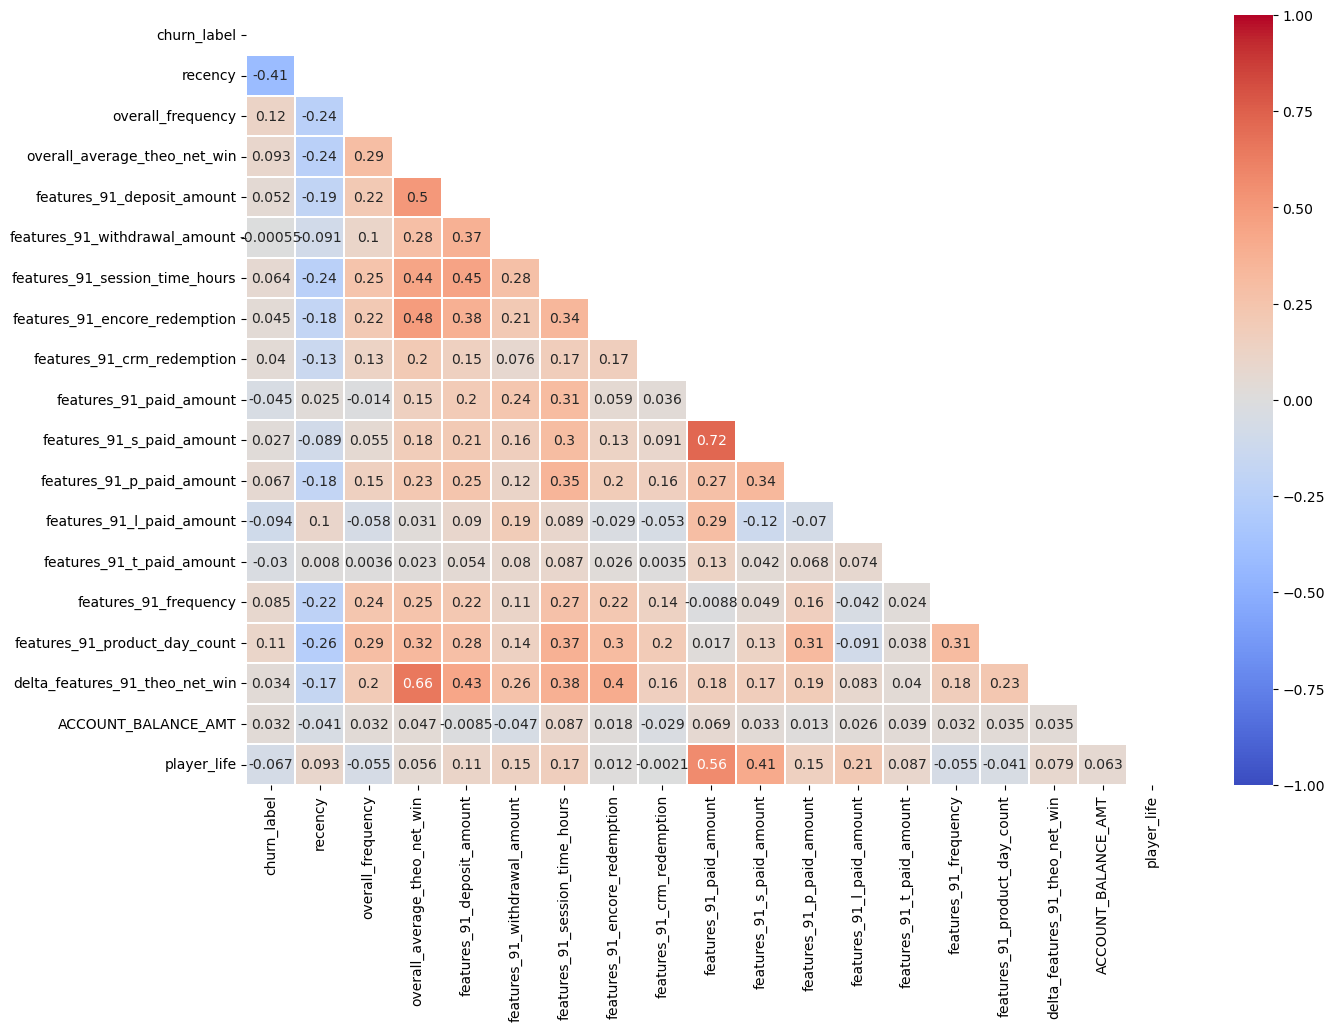

In [24]:
plt.figure(figsize=(15, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [25]:
#sns.pairplot(df, hue='churn_label')

In [26]:
c_labels = ['Not Churn','Churn']

# Define the colors
colors = ['#4C78A8','#F58518']

# Create a pie chart
fig = go.Figure()

# Add a trace to the pie chart with specified colors
fig.add_trace(go.Pie(
    labels=c_labels, 
    values=df['churn_label'].value_counts(), 
    name="Churn",
    marker=dict(colors=colors)  # Set the colors
))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

# Show the plot
fig.show()

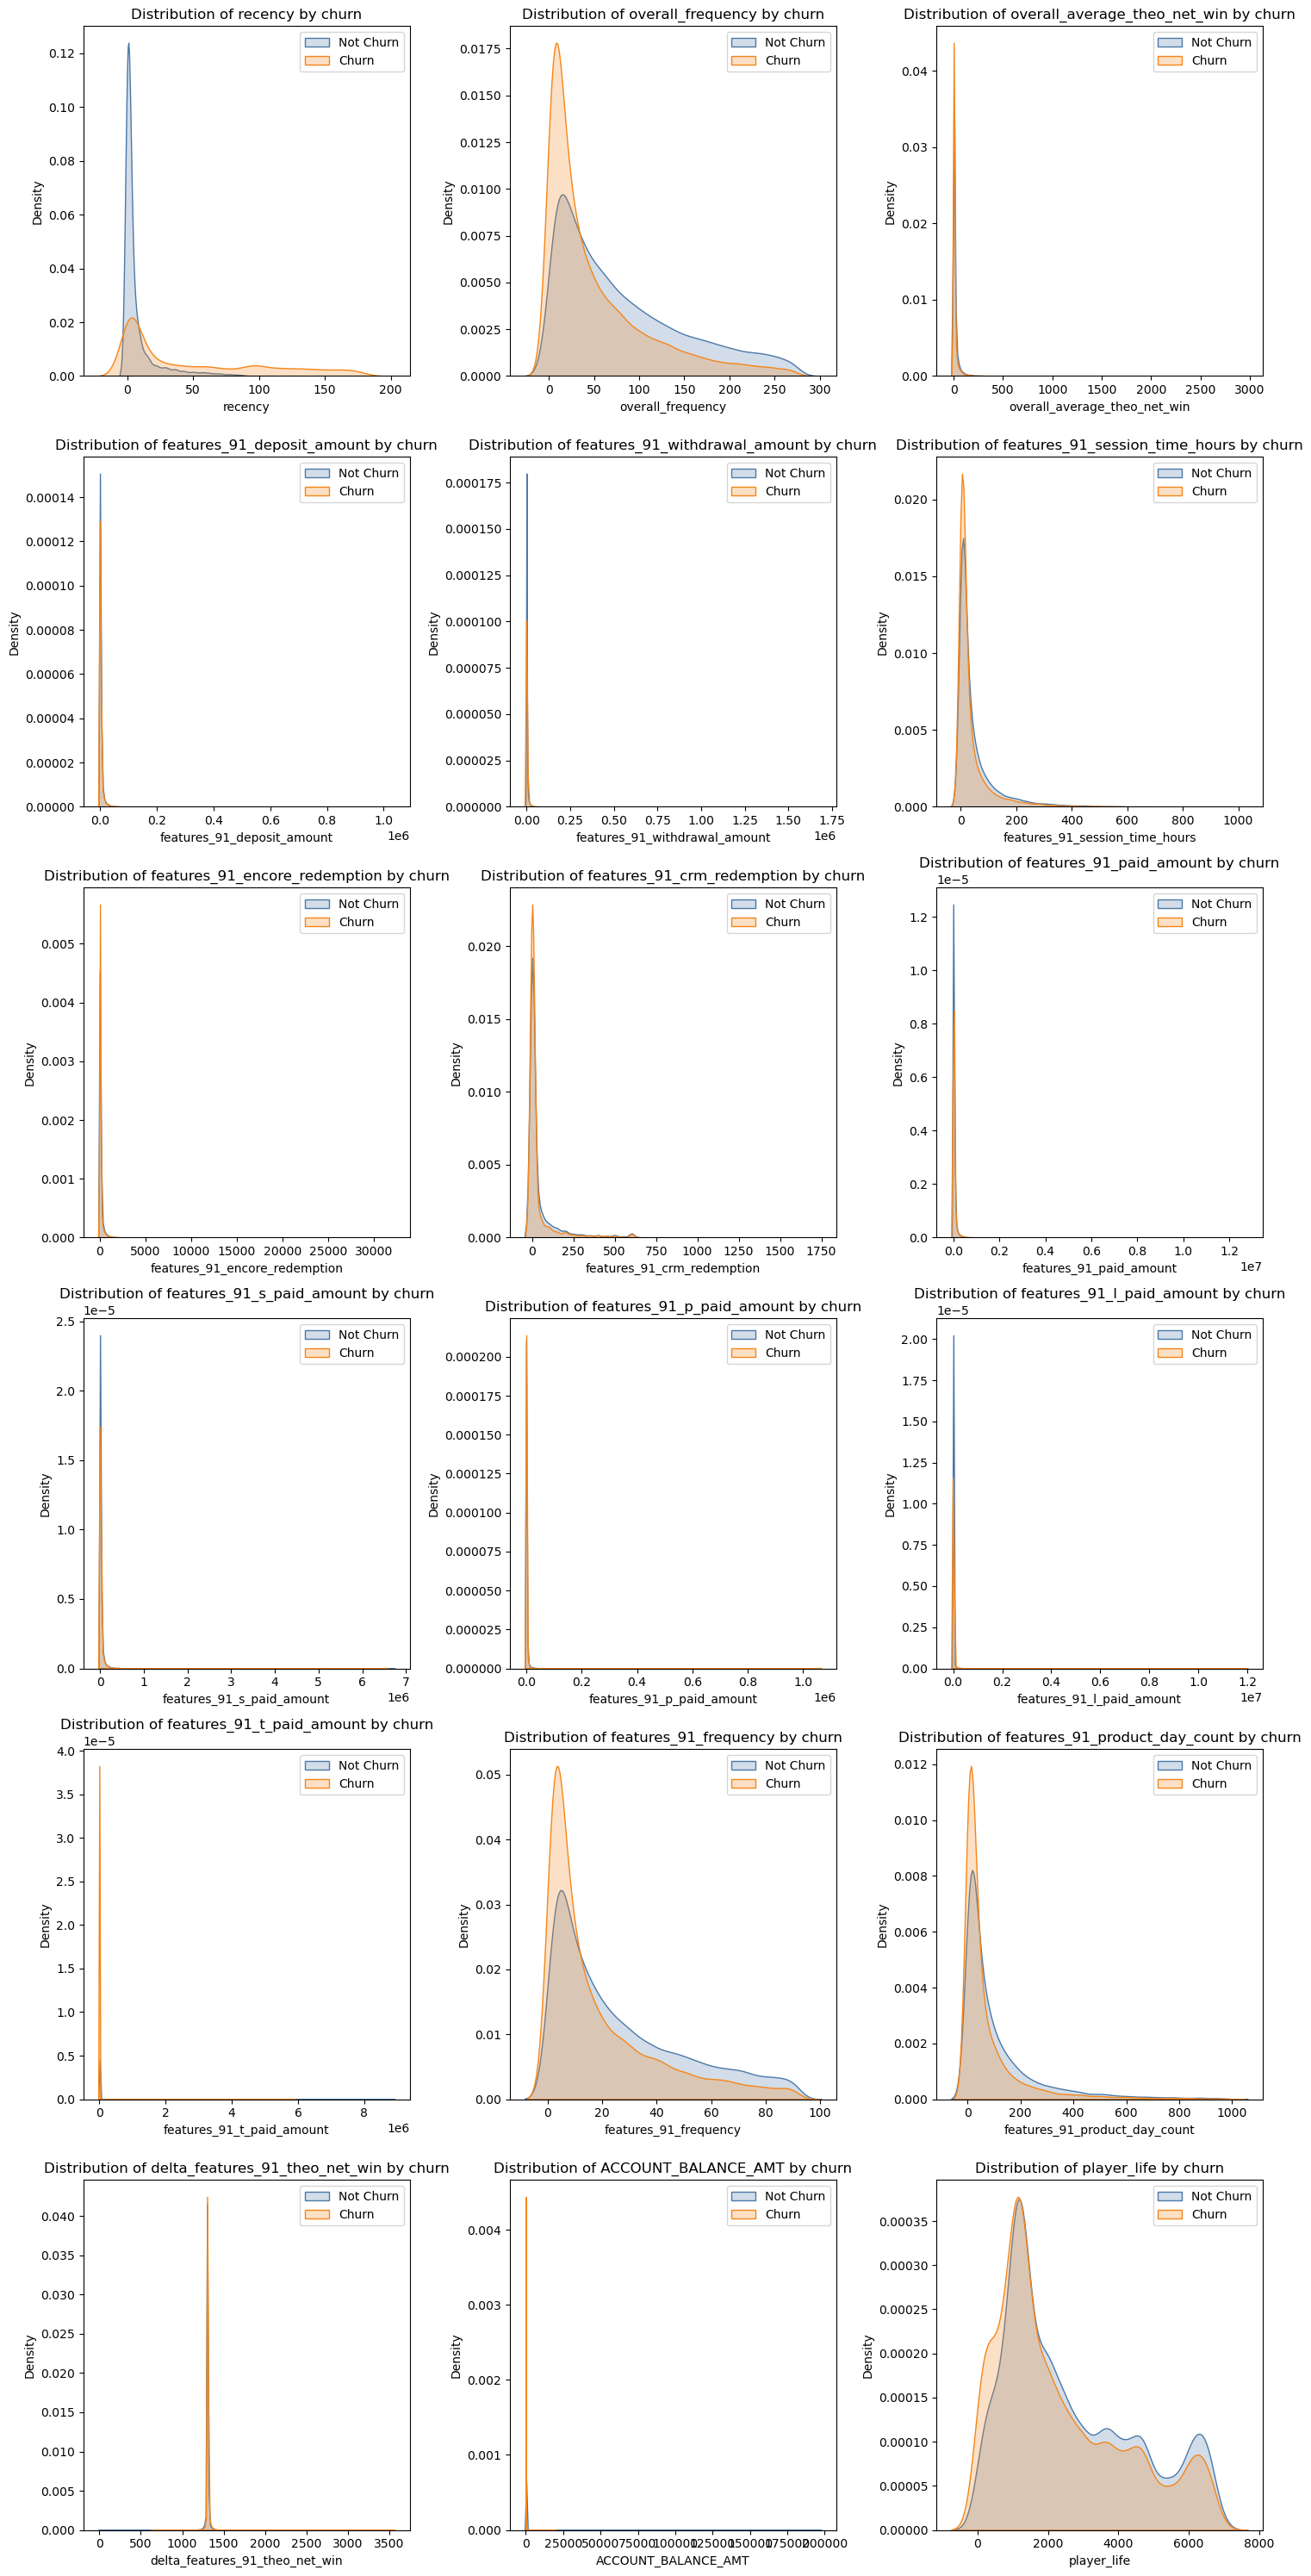

In [27]:
# Identify numeric columns (excluding 'churn_label')
numeric_columns = df.select_dtypes(include='number').columns.drop('churn_label')

# Calculate number of rows needed
num_plots = len(numeric_columns)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Iterate through numeric columns and create KDE plots
for i, column in enumerate(numeric_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = sns.kdeplot(df[column][(df["churn_label"] == 0)], color="#4C78A8", fill=True, ax=axes[row_idx, col_idx])
    ax = sns.kdeplot(df[column][(df["churn_label"] == 1)], ax=ax, color="#F58518", fill=True)
    ax.legend(["Not Churn", "Churn"], loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(column)
    ax.set_title(f'Distribution of {column} by churn')

# Adjust layout
plt.tight_layout()
plt.show()

In [28]:
df_transformed = df.copy()
df_transformed  = df_transformed.drop(columns='churn_label')
df_transformed = np.log(df_transformed+1)


In [29]:
df_transformed.isna().sum()

recency                           0
overall_frequency                 0
overall_average_theo_net_win      0
features_91_deposit_amount        0
features_91_withdrawal_amount     0
features_91_session_time_hours    0
features_91_encore_redemption     0
features_91_crm_redemption        0
features_91_paid_amount           0
features_91_s_paid_amount         0
features_91_p_paid_amount         0
features_91_l_paid_amount         0
features_91_t_paid_amount         0
features_91_frequency             0
features_91_product_day_count     0
delta_features_91_theo_net_win    0
ACCOUNT_BALANCE_AMT               0
player_life                       0
dtype: int64

In [30]:
inf_values = np.isinf(df_transformed).sum()
inf_values

recency                           0
overall_frequency                 0
overall_average_theo_net_win      0
features_91_deposit_amount        0
features_91_withdrawal_amount     0
features_91_session_time_hours    0
features_91_encore_redemption     0
features_91_crm_redemption        0
features_91_paid_amount           0
features_91_s_paid_amount         0
features_91_p_paid_amount         0
features_91_l_paid_amount         0
features_91_t_paid_amount         0
features_91_frequency             0
features_91_product_day_count     0
delta_features_91_theo_net_win    0
ACCOUNT_BALANCE_AMT               0
player_life                       0
dtype: int64

In [31]:
df_transformed=df_transformed.fillna(0)

In [32]:
df_transformed['churn_label'] = df['churn_label']

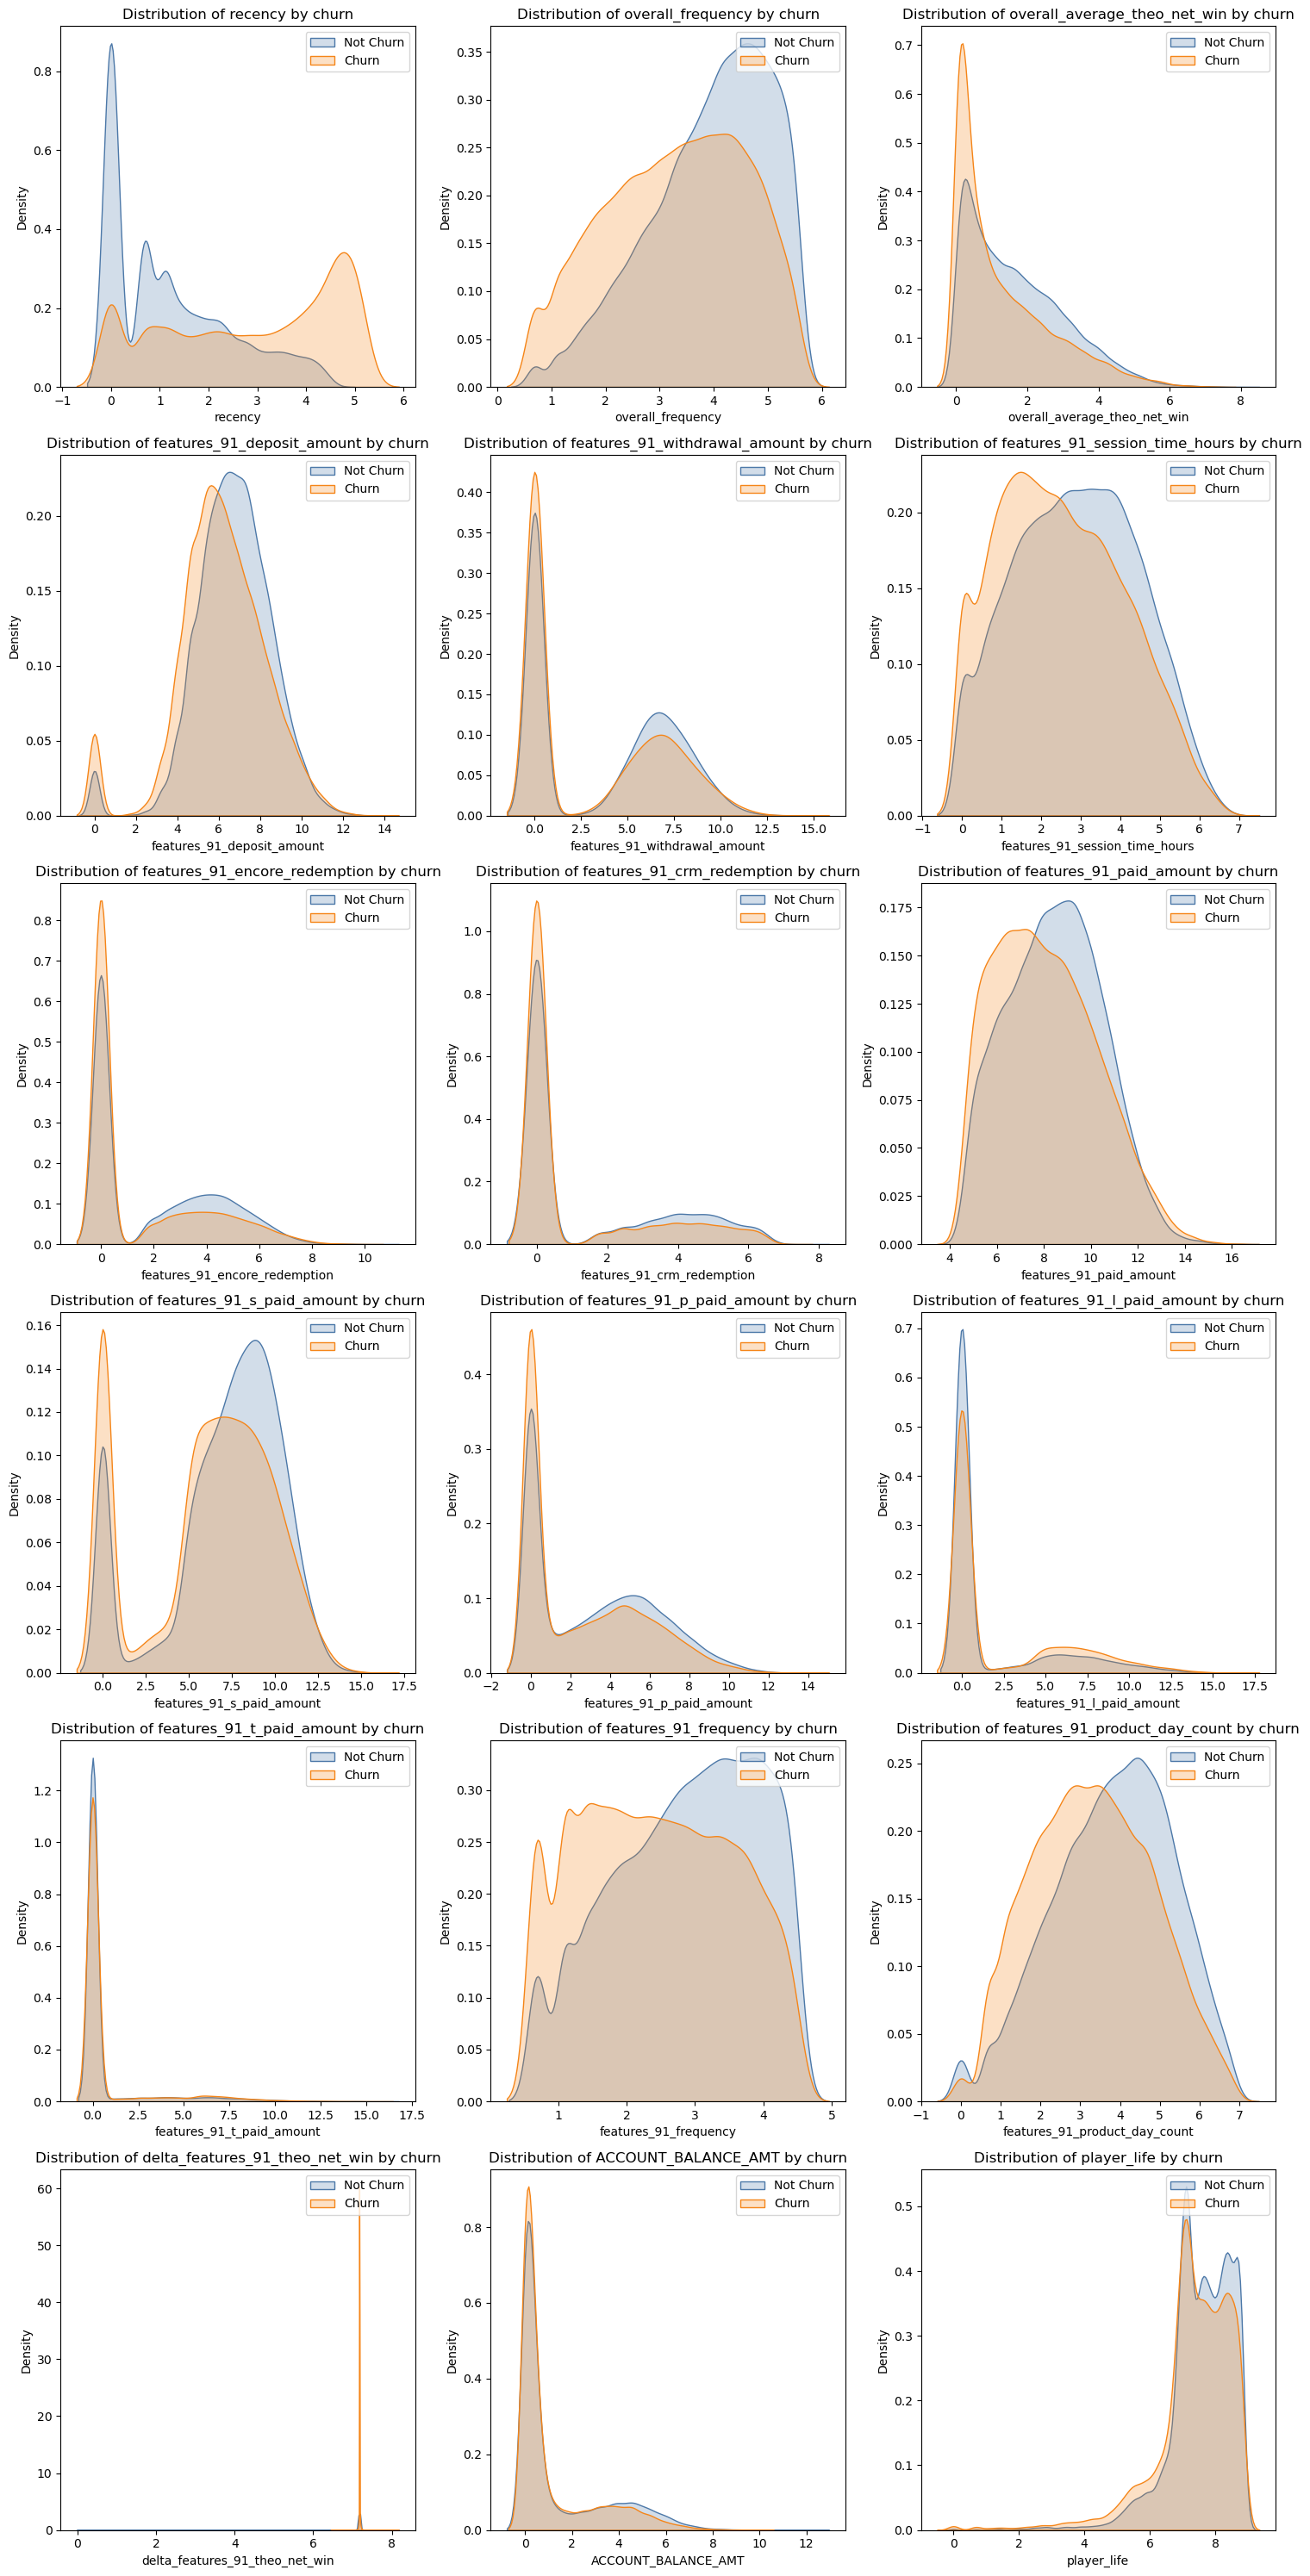

In [33]:
# Identify numeric columns (excluding 'churn_label')
numeric_columns = df_transformed.select_dtypes(include='number').columns.drop('churn_label')

# Calculate number of rows needed
num_plots = len(numeric_columns)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Iterate through numeric columns and create KDE plots
for i, column in enumerate(numeric_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = sns.kdeplot(df_transformed[column][(df_transformed["churn_label"] == 0)], color="#4C78A8", fill=True, ax=axes[row_idx, col_idx])
    ax = sns.kdeplot(df_transformed[column][(df_transformed["churn_label"] == 1)], ax=ax, color="#F58518", fill=True)
    ax.legend(["Not Churn", "Churn"], loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(column)
    ax.set_title(f'Distribution of {column} by churn')

# Adjust layout
plt.tight_layout()
plt.show()

In [34]:
X = df.drop('churn_label', axis=1)
y = df['churn_label']

In [35]:
X_const = sm.add_constant(X)
linearregression = sm.OLS(y, X_const)
results = linearregression.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            churn_label   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     908.6
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:51:05   Log-Likelihood:                -27784.
No. Observations:               47636   AIC:                         5.560e+04
Df Residuals:                   47618   BIC:                         5.576e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -26.5554     36.693     -0.724      0.469     -98.474      45.363
recency                            0.0053   5.02e-05    106.597      0.000       0.005       0.005
overall_frequency                 -0.0025   8.46e-05    -29.790      0.000      -0.003      -0.002
overall_average_theo_net_win       0.0205      0.028      0.728      0.466      -0.035       0.076
features_91_deposit_amount     -1.559e-06   3.19e-07     -4.883      0.000   -2.18e-06   -9.33e-07
features_91_withdrawal_amount   6.558e-07   1.78e-07      3.682      0.000    3.07e-07       1e-06
features_91_session_time_hours     0.0001   3.39e-05      3.038      0.002    3.65e-05       0.000
features_91_encore_redemption   1.941e-06   7.39e-06      0.263      0.793   -1.25e-05    1.64e-05
features_91_crm_redemption         0.0001   2.19e-05      6.281      0.000    9.46e-05       0.000
features_91_paid_amount         -7.15e-06      1e-05     -0.714      0.475   -2.68e-05    1.25e-05
features_91_s_paid_amount      -3.879e-06   5.43e-06     -0.715      0.475   -1.45e-05    6.75e-06
features_91_p_paid_amount      -8.273e-06   1.16e-05     -0.713      0.476    -3.1e-05    1.45e-05
features_91_l_paid_amount       2.258e-06   3.22e-06      0.701      0.484   -4.06e-06    8.58e-06
features_91_t_paid_amount       3.007e-06   4.15e-06      0.725      0.469   -5.13e-06    1.11e-05
features_91_frequency              0.0067      0.000     24.845      0.000       0.006       0.007
features_91_product_day_count  -3.145e-05    1.9e-05     -1.651      0.099   -6.88e-05    5.88e-06
delta_features_91_theo_net_win     0.0206      0.028      0.733      0.464      -0.034       0.076
ACCOUNT_BALANCE_AMT            -4.847e-06   1.62e-06     -3.000      0.003   -8.01e-06   -1.68e-06
player_life                    -4.118e-06   1.08e-06     -3.798      0.000   -6.24e-06   -1.99e-06
==============================================================================
Omnibus:                   568103.465   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5300.833
Skew:                           0.479   Prob(JB):                         0.00
Kurtosis:                       1.675   Cond. No.                     6.46e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.33e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
my_PCA = PCA(n_components=0.8)
my_PCA.fit(X_scaled)
X_pca = my_PCA.transform(X_scaled)
X_pca

array([[ 4.0568915 , -4.47468113,  2.18346017, ...,  0.11768336,
         0.41129789,  0.27974016],
       [-0.32236121, -0.16694463,  0.2260084 , ..., -1.14829727,
        -0.18528299, -0.03479205],
       [-0.50863581, -0.0419264 ,  0.2216376 , ..., -1.14439014,
        -0.08033437, -0.11120762],
       ...,
       [-1.28689394,  1.24478774, -0.23415946, ...,  0.48582595,
         0.0432759 ,  0.16643861],
       [-1.20151145,  1.01030958, -0.09771195, ...,  0.40258431,
        -0.04721823,  0.1807875 ],
       [-1.24357193,  1.03419855, -0.09823073, ...,  0.39858583,
        -0.03535531,  0.15426602]])

In [38]:
X = df_transformed.drop('churn_label', axis=1)
y = df_transformed['churn_label']

In [39]:
X_const = sm.add_constant(X)
linearregression = sm.OLS(y, X_const)
results = linearregression.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            churn_label   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     1011.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:51:05   Log-Likelihood:                -26770.
No. Observations:               47636   AIC:                         5.358e+04
Df Residuals:                   47617   BIC:                         5.374e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.4155      0.317     -4.460      0.000      -2.038      -0.793
recency                            0.1661      0.002    109.407      0.000       0.163       0.169
overall_frequency                 -0.0519      0.005    -11.412      0.000      -0.061      -0.043
overall_average_theo_net_win      -0.0405      0.004     -9.953      0.000      -0.048      -0.033
features_91_deposit_amount        -0.0270      0.002    -15.380      0.000      -0.030      -0.024
features_91_withdrawal_amount      0.0036      0.001      5.005      0.000       0.002       0.005
features_91_session_time_hours     0.0139      0.002      5.862      0.000       0.009       0.018
features_91_encore_redemption      0.0027      0.001      2.226      0.026       0.000       0.005
features_91_crm_redemption         0.0036      0.001      3.199      0.001       0.001       0.006
features_91_paid_amount            0.0579      0.003     19.343      0.000       0.052       0.064
features_91_s_paid_amount          0.0016      0.001      1.555      0.120      -0.000       0.004
features_91_p_paid_amount          0.0038      0.001      4.797      0.000       0.002       0.005
features_91_l_paid_amount          0.0008      0.001      0.970      0.332      -0.001       0.002
features_91_t_paid_amount          0.0005      0.001      0.470      0.638      -0.001       0.002
features_91_frequency              0.0785      0.006     12.483      0.000       0.066       0.091
features_91_product_day_count     -0.0059      0.002     -2.474      0.013      -0.011      -0.001
delta_features_91_theo_net_win     0.1761      0.044      3.972      0.000       0.089       0.263
ACCOUNT_BALANCE_AMT                0.0017      0.001      1.533      0.125      -0.000       0.004
player_life                       -0.0054      0.002     -2.930      0.003      -0.009      -0.002
==============================================================================
Omnibus:                     6103.620   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2110.783
Skew:                           0.281   Prob(JB):                         0.00
Kurtosis:                       2.136   Cond. No.                     3.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
my_PCA = PCA(n_components=0.8)
my_PCA.fit(X_scaled)
X_pca = my_PCA.transform(X_scaled)
num_dimensions = X_pca[1]
len(num_dimensions)

array([ 0.7363684 ,  1.09545547,  0.23676367, -0.17401474, -0.06109211,
       -0.5893495 ,  0.78538073,  1.05722065])

# 2.Machine Learning Model Evaluations and Predictions

# 2.1 Train, Validation, Test split

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [43]:
# X = df_transformed.drop('churn_label', axis=1)
# y = df_transformed['churn_label']

X = df.drop('churn_label', axis=1)
y = df['churn_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
X_test

array([[ 1.86165741e+00, -2.03876333e-01, -2.58035260e-01, ...,
         4.07025197e-03, -1.29957058e-01,  5.42536814e-01],
       [-5.65897836e-01, -6.39105932e-01, -2.63441826e-01, ...,
         3.22217520e-02, -1.30002882e-01, -6.11523469e-01],
       [ 7.95348095e-01, -3.83971339e-01, -2.13291267e-01, ...,
        -1.99106554e-02, -1.30163263e-01, -7.39752389e-01],
       ...,
       [ 6.93502650e-02, -7.74177187e-01, -2.61391060e-01, ...,
        -3.29437573e-02, -1.30071616e-01,  5.14520411e-01],
       [-5.88585268e-01,  5.31511610e-01, -1.98003735e-01, ...,
         4.20983456e-04, -1.30025793e-01,  2.18041882e+00],
       [-5.65897836e-01, -6.84129684e-01, -2.69034826e-01, ...,
         1.81460020e-02, -1.30117440e-01, -5.14543613e-01]])

In [45]:
len(X_train)

33345

In [46]:
len(X_test)

14291

# 2.2 Train and Evaluate function

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


In [48]:
# Function to train and evaluate a model and return ROC-AUC score
def train_evaluate_model(clf, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    fitted_search = grid_search.fit(X_train, y_train)
    best_params = fitted_search.best_params_
    
    clf = clf.set_params(**best_params)
    clf.fit(X_train, y_train)

    y_probabilities = clf.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probabilities)
    
    return clf, roc_auc, y_probabilities, best_params

# DataFrames for storing results
results_dfs = []

# 2.3 Models

# 2.3.1 Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
# RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [5, 10, 25, 50]}
rf_model, rf_roc_auc, rf_probabilities, rf_best_params = train_evaluate_model(rf_clf, rf_param_grid, X_train, y_train, X_test, y_test)
results_df_rf = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': rf_probabilities})
results_df_rf.set_index('CustomerID', inplace=True)
results_dfs.append(('RandomForest', rf_roc_auc, results_df_rf))

# 2.3.2 XGBoost

In [51]:
from xgboost import XGBClassifier

In [52]:
# XGBClassifier
xgb_clf = XGBClassifier(random_state=42)
xgb_param_grid = {'n_estimators': [5, 10, 25, 50]}
xgb_model, xgb_roc_auc, xgb_probabilities, xgb_best_params = train_evaluate_model(xgb_clf, xgb_param_grid, X_train, y_train, X_test, y_test)
results_df_xgb = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': xgb_probabilities})
results_df_xgb.set_index('CustomerID', inplace=True)
results_dfs.append(('XGBClassifier', xgb_roc_auc, results_df_xgb))

# 2.3.3 GradientBoosting

In [53]:
 from sklearn.ensemble import GradientBoostingClassifier

In [54]:
# GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_param_grid = {'loss': ['log_loss', 'exponential'], 'learning_rate': [0.001, 0.1, 1, 10], 'n_estimators': [5, 10, 25, 50]}
gb_model, gb_roc_auc, gb_probabilities, gb_best_params = train_evaluate_model(gb_clf, gb_param_grid, X_train, y_train, X_test, y_test)
results_df_gb = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': gb_probabilities})
results_df_gb.set_index('CustomerID', inplace=True)
results_dfs.append(('GradientBoosting', gb_roc_auc, results_df_gb))

# 2.3.4 KNearestNeighbors

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
# K-Nearest Neighbors (KNN)
knn_clf = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': list(range(1, 20))}
knn_model, knn_roc_auc, knn_probabilities, knn_best_params = train_evaluate_model(knn_clf, knn_param_grid, X_train, y_train, X_test, y_test)
results_df_knn = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': knn_probabilities})
results_df_knn.set_index('CustomerID', inplace=True)
results_dfs.append(('KNN', knn_roc_auc, results_df_knn))

# 2.3.5 Support Vector Machines

In [57]:
# from sklearn.svm import SVC

In [58]:
# # Support Vector Machines (SVM)
# svm_clf = SVC(probability=True)
# svm_param_grid = {'C': [1], 'kernel': ['linear', 'rbf']}
# svm_model, svm_roc_auc, svm_probabilities, svm_best_params = train_evaluate_model(svm_clf, svm_param_grid, X_train, y_train, X_test, y_test)
# results_df_svm = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': svm_probabilities})
# results_df_svm.set_index('CustomerID', inplace=True)
# results_dfs.append(('SVM', svm_roc_auc, results_df_svm))

# 2.3.6 Naive Bayes (Gaussian)

In [59]:
from sklearn.naive_bayes import GaussianNB

In [60]:
# Gaussian Naive Bayes
nb_clf = GaussianNB()
nb_model, nb_roc_auc, nb_probabilities, nb_best_params = train_evaluate_model(nb_clf, {}, X_train, y_train, X_test, y_test)
results_df_nb = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': nb_probabilities})
results_df_nb.set_index('CustomerID', inplace=True)
results_dfs.append(('NaiveBayes', nb_roc_auc, results_df_nb))

# 2.3.7 Neural Network - sklearn

In [61]:
from sklearn.neural_network import MLPClassifier

In [62]:
# Neural Network (MLPClassifier)
nn_clf = MLPClassifier(max_iter=1000, random_state=42)  # You can adjust max_iter and other parameters
nn_param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50)]}
nn_model, nn_roc_auc, nn_probabilities, nn_best_params = train_evaluate_model(nn_clf, nn_param_grid, X_train, y_train, X_test, y_test)
results_df_nn = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': nn_probabilities})
results_df_nn.set_index('CustomerID', inplace=True)
results_dfs.append(('NeuralNetwork', nn_roc_auc, results_df_nn))

In [63]:
nn_clf = MLPClassifier(**nn_best_params,max_iter=1000, random_state=42)
y_pred_nn = nn_clf.fit(X_train, y_train)
# Make predictions on the test set
y_pred_nn = nn_clf.predict(X_test)
y_pred_nn  

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

# 2.3.8 Neural Network - TensorFlow

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [65]:
# TensorFlow/Keras
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Neural Network with TensorFlow/Keras
nn_tf_model = build_neural_network(X_train.shape[1])
nn_tf_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions on the test set
nn_tf_probabilities = nn_tf_model.predict(X_test)
nn_tf_roc_auc = roc_auc_score(y_test, nn_tf_probabilities)

# Create a DataFrame with customer IDs and their corresponding probabilities
results_df_nn_tf = pd.DataFrame({'CustomerID':  y_test.index, 'Churn_Probability': nn_tf_probabilities.flatten()})
results_df_nn_tf.set_index('CustomerID', inplace=True)
results_dfs.append(('NeuralNetwork_TF', nn_tf_roc_auc, results_df_nn_tf))





447/447 [==============================] - 1s 1ms/step


# 2.3.9 Neural Network - PyTorch

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [67]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


# Define the neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Instantiate the neural network
input_size = X_train_tensor.shape[1]
nn_pytorch_model = NeuralNetwork(input_size)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_pytorch_model.parameters(), lr=0.001)

# Train the neural network
for epoch in range(10):  # You can adjust the number of epochs
    outputs = nn_pytorch_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Make predictions on the test set
nn_pytorch_model.eval()
with torch.no_grad():
    nn_pytorch_probabilities = nn_pytorch_model(X_test_tensor).numpy()

# Create a DataFrame with customer IDs and their corresponding probabilities
results_df_nn_pytorch = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': nn_pytorch_probabilities.flatten()})
results_df_nn_pytorch.set_index('CustomerID', inplace=True)
results_dfs.append(('NeuralNetwork_PyTorch', 0.0, results_df_nn_pytorch))  # ROC-AUC not computed for simplicity

# 2.4 Find Best Model

In [68]:
from sklearn.metrics import classification_report

def train_evaluate_model_class_report(model, X_train, y_train, X_test, y_test, model_name):
    
    # Make predictions on the test set
    if model_name == "NeuralNetwork_PyTorch":
        # For PyTorch neural network model
        threshold=0.5
        y_prob = nn_pytorch_model(X_test_tensor).detach().numpy()
        y_pred = (y_prob > threshold).astype(int)  # Convert probabilities to class labels
        # Display classification report
        report = classification_report(y_test, y_pred)
        
    elif model_name == "NeuralNetwork_TF":
        # For TensorFlow neural network model
        model.fit(X_train, y_train)
        threshold=0.5
        y_prob = model.predict(X_test)  # Assuming model is a TensorFlow model with predict method
        y_pred = (y_prob > threshold).astype(int)  # Convert probabilities to class labels
        # Display classification report with plot
        report = classification_report(y_test, y_pred)
        lines = report.split('\n')
        report = '\n'.join(line for line in lines if '=====' not in line)
    else:
        # For other models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Display classification report
        report = classification_report(y_test, y_pred)
    
    print(f"Classification Report - {model_name}:\n{report}")

    # Return the model for further analysis if needed
    return model

In [69]:
# Train, evaluate, and display classification report for each model
models = [
    ('RandomForest', RandomForestClassifier(**rf_best_params, random_state=42)),
    ('XGBoost', XGBClassifier(**xgb_best_params, random_state=42)),
    ('GradientBoosting', GradientBoostingClassifier(**gb_best_params)),
    ('KNN', KNeighborsClassifier(**knn_best_params)),
#    ('SVM', SVC(probability=True)),
    ('NaiveBayes', GaussianNB(**nb_best_params)),
    ('NeuralNetwork', MLPClassifier(**nn_best_params,max_iter=1000, random_state=42)),
    ('NeuralNetwork_TF', build_neural_network(X_train.shape[1])),
    ('NeuralNetwork_PyTorch', NeuralNetwork(input_size)),
]

for model_name, model in models:
    train_evaluate_model_class_report(model, X_train, y_train, X_test, y_test, model_name)

Classification Report - RandomForest:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76      7579
           1       0.76      0.61      0.68      6712

    accuracy                           0.73     14291
   macro avg       0.74      0.72      0.72     14291
weighted avg       0.73      0.73      0.72     14291

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      7579
           1       0.77      0.62      0.69      6712

    accuracy                           0.74     14291
   macro avg       0.74      0.73      0.73     14291
weighted avg       0.74      0.74      0.73     14291

Classification Report - GradientBoosting:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      7579
           1       0.78      0.60      0.68      6712

    accuracy                           0.73     14291
   macro avg   

In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [71]:
# Initialize the figure
fig = go.Figure()

# RandomForestClassifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fig.add_trace(go.Scatter(x=fpr_rf, y=tpr_rf, mode='lines', name=f'RandomForest (AUC = {roc_auc_rf:.2f})'))

# XGBClassifier
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probabilities)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
fig.add_trace(go.Scatter(x=fpr_xgb, y=tpr_xgb, mode='lines', name=f'XGBClassifier (AUC = {roc_auc_xgb:.2f})'))

# GradientBoostingClassifier
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probabilities)
roc_auc_gb = auc(fpr_gb, tpr_gb)
fig.add_trace(go.Scatter(x=fpr_gb, y=tpr_gb, mode='lines', name=f'GradientBoosting (AUC = {roc_auc_gb:.2f})'))

# K-Nearest Neighbors (KNN)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probabilities)
roc_auc_knn = auc(fpr_knn, tpr_knn)
fig.add_trace(go.Scatter(x=fpr_knn, y=tpr_knn, mode='lines', name=f'KNN (AUC = {roc_auc_knn:.2f})'))

# Naive Bayes (Gaussian)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probabilities)
roc_auc_nb = auc(fpr_nb, tpr_nb)
fig.add_trace(go.Scatter(x=fpr_nb, y=tpr_nb, mode='lines', name=f'NaiveBayes (AUC = {roc_auc_nb:.2f})'))

# Neural Network (MLPClassifier)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probabilities)
roc_auc_nn = auc(fpr_nn, tpr_nn)
fig.add_trace(go.Scatter(x=fpr_nn, y=tpr_nn, mode='lines', name=f'NeuralNetwork (AUC = {roc_auc_nn:.2f})'))

# Neural Network with TensorFlow/Keras
fpr_nn_tf, tpr_nn_tf, _ = roc_curve(y_test, nn_tf_probabilities)
roc_auc_nn_tf = auc(fpr_nn_tf, tpr_nn_tf)
fig.add_trace(go.Scatter(x=fpr_nn_tf, y=tpr_nn_tf, mode='lines', name=f'NeuralNetwork_TF (AUC = {roc_auc_nn_tf:.2f})'))

# Neural Network with PyTorch
fpr_nn_pytorch, tpr_nn_pytorch, _ = roc_curve(y_test, nn_pytorch_probabilities)
roc_auc_nn_pytorch = auc(fpr_nn_pytorch, tpr_nn_pytorch)
fig.add_trace(go.Scatter(x=fpr_nn_pytorch, y=tpr_nn_pytorch, mode='lines', name=f'NeuralNetwork_PyTorch (AUC = {roc_auc_nn_pytorch:.2f})'))

# Add the diagonal line
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Diagonal'))

# Update layout
fig.update_layout(
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    title='Receiver Operating Characteristic (ROC) Curve',
    legend=dict(x=0, y=1.1),
    margin=dict(l=20, r=20, t=40, b=20)
)

# Show the figure
fig.show()

In [72]:
# Find the model with the highest ROC-AUC score
best_model, _, best_results_df = max(results_dfs, key=lambda x: x[1])

In [73]:
best_results_df

Churn_Probability
CustomerID                   
459232               0.999511
764546               0.495956
908135               0.893869
554628               0.673012
98157                0.252199
...                       ...
412476               0.503710
11454                0.482610
464461               0.250828
18173                0.341932
725846               0.431583

[14291 rows x 1 columns]